/Users/aliefchandrawijaya/trading_bot/venv/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


✅ 1. Libraries imported successfully.

🔄 2. Preparing data...
   Local data not found. Fetching from exchange (this will only happen once)...
   Fetching H1 data...
   Resampling H1 data to create H4 data (Layar 1)...
   Fetching M15 data (Layar 3)...

   ✅ Successfully fetched data.
   Saving data to CSV files for future runs...
   Data caching complete.

🛠️  3. Calculating indicators for all timeframes...
   Indicators calculated successfully.

⚙️  4. Running Intraday Triple Screen backtesting with Trailing Stop...
   Backtesting simulation complete.

📊 5. Analyzing performance and creating plot...

--- Intraday Backtest Results ---
Total Trades: 459
Win Rate: 56.86%
Profit Factor: 3.16
------------------------



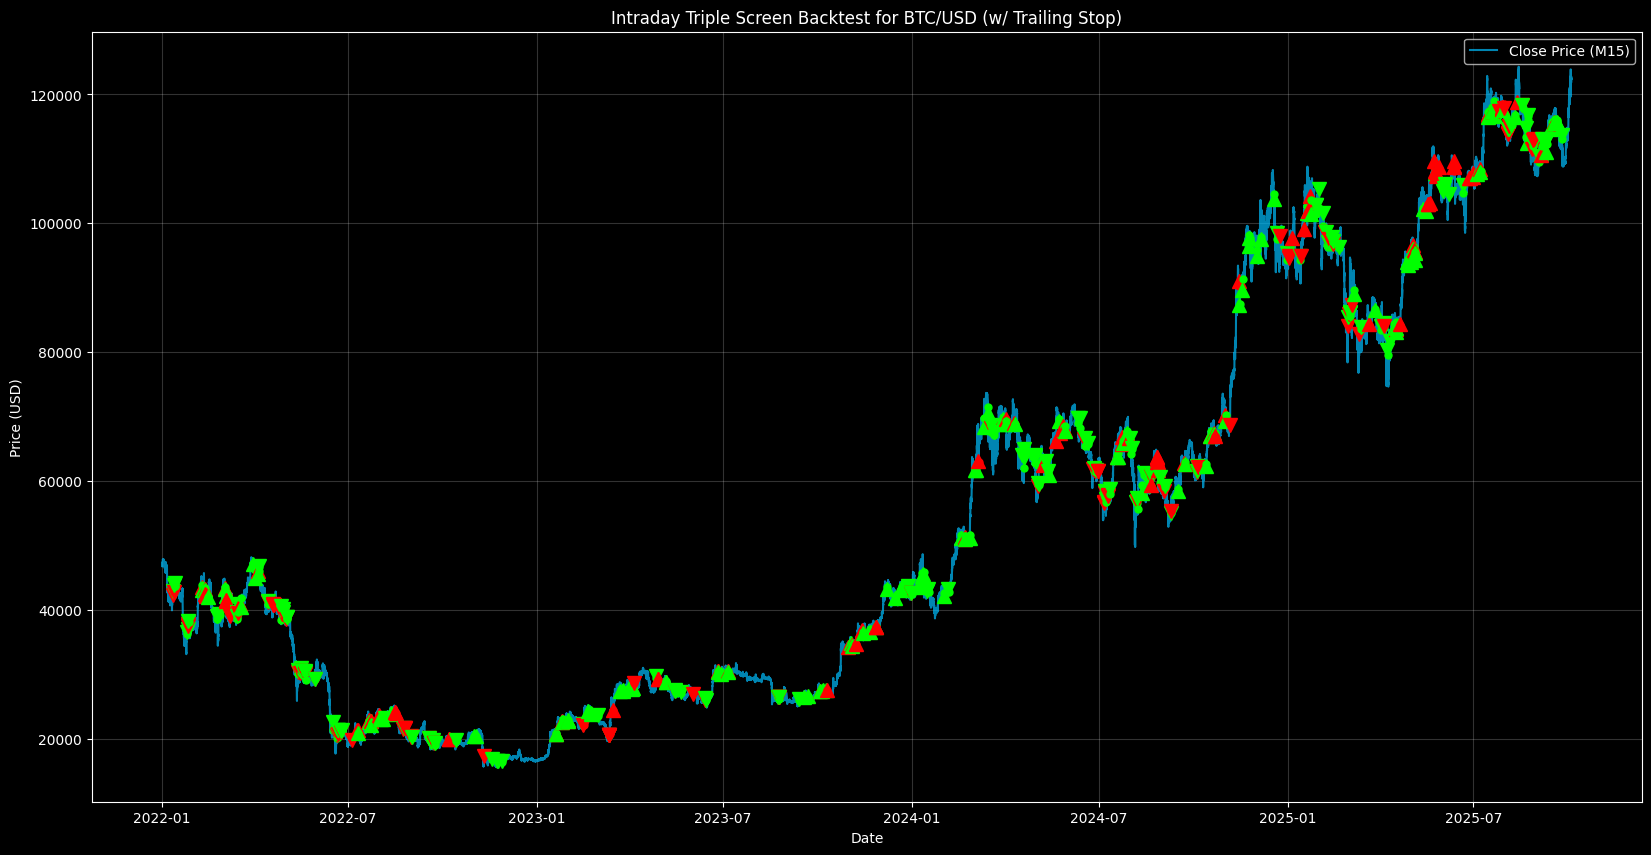

In [1]:
# ==============================================================================
# STRATEGI "TRIPLE SCREEN INTRADAY" (H4 -> H1 -> M15) - V1.4 (CSV Caching)
# ==============================================================================

# === 1. SETUP & IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import ccxt
import pandas_ta as ta
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from IPython.display import display
import time

print("✅ 1. Libraries imported successfully.")


# === 2. DATA FETCHING & CACHING (DISIMPAN KE CSV) ===
print("\n🔄 2. Preparing data...")
# Tentukan nama file cache
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
h4_file = os.path.join(data_dir, 'btc_h4_data.csv')
h1_file = os.path.join(data_dir, 'btc_h1_data.csv')
m15_file = os.path.join(data_dir, 'btc_m15_data.csv')

# Cek apakah semua file cache sudah ada
if os.path.exists(h4_file) and os.path.exists(h1_file) and os.path.exists(m15_file):
    print("   Loading data from local CSV files...")
    df_h4 = pd.read_csv(h4_file, index_col='timestamp', parse_dates=True)
    df_h1 = pd.read_csv(h1_file, index_col='timestamp', parse_dates=True)
    df_m15 = pd.read_csv(m15_file, index_col=0, parse_dates=['timestamp']) # index_col=0 karena kita reset_index sebelumnya
    print("   ✅ Data loaded successfully from cache.")

else:
    print("   Local data not found. Fetching from exchange (this will only happen once)...")
    df_h4 = pd.DataFrame(); df_h1 = pd.DataFrame(); df_m15 = pd.DataFrame()
    try:
        exchange = ccxt.coinbaseadvanced()
        exchange.proxies = {'http': None, 'https': None}
        symbol_input = 'BTC/USD'; start_date = "2022-01-01"; ccxt_symbol = symbol_input.replace('/', '-')

        print("   Fetching H1 data..."); since = exchange.parse8601(f"{start_date} 00:00:00Z"); all_ohlcv_h1 = []
        while True:
            ohlcv_chunk = exchange.fetch_ohlcv(ccxt_symbol, '1h', since, limit=300)
            if not ohlcv_chunk: break
            all_ohlcv_h1.extend(ohlcv_chunk); since = ohlcv_chunk[-1][0] + 1; time.sleep(exchange.rateLimit / 1000)
        df_h1 = pd.DataFrame(all_ohlcv_h1, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']); df_h1['timestamp'] = pd.to_datetime(df_h1['timestamp'], unit='ms'); df_h1.set_index('timestamp', inplace=True)
        
        print("   Resampling H1 data to create H4 data (Layar 1)...")
        agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
        df_h4 = df_h1.resample('4H', origin='start_day').agg(agg_dict).dropna()

        print("   Fetching M15 data (Layar 3)..."); since = exchange.parse8601(f"{start_date} 00:00:00Z"); all_ohlcv_m15 = []
        while True:
            ohlcv_chunk = exchange.fetch_ohlcv(ccxt_symbol, '15m', since, limit=300)
            if not ohlcv_chunk: break
            all_ohlcv_m15.extend(ohlcv_chunk); since = ohlcv_chunk[-1][0] + 1; time.sleep(exchange.rateLimit / 1000)
        df_m15 = pd.DataFrame(all_ohlcv_m15, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']); df_m15['timestamp'] = pd.to_datetime(df_m15['timestamp'], unit='ms')

        print(f"\n   ✅ Successfully fetched data.")
        
        # Simpan data ke CSV untuk penggunaan berikutnya
        print("   Saving data to CSV files for future runs...")
        df_h4.to_csv(h4_file)
        df_h1.to_csv(h1_file)
        df_m15.to_csv(m15_file)
        print("   Data caching complete.")

    except Exception as e:
        print(f"   ❌ ERROR during data fetching: {type(e).__name__} - {e}")

if not df_h4.empty and not df_h1.empty and not df_m15.empty:
    # (Sisa kode dari langkah 3 sampai 5 tetap sama persis, tidak perlu diubah)
    # === 3. CALCULATE INDICATORS ===
    print("\n🛠️  3. Calculating indicators for all timeframes...")
    df_h4['EMA_55'] = ta.ema(df_h4['close'], length=55)
    
    df_h1['RSI_14'] = ta.rsi(df_h1['close'], length=14); df_h1['ATR_14'] = ta.atr(df_h1['high'], df_h1['low'], df_h1['close'], length=14)
    peak_indices, _ = find_peaks(df_h1['high'], distance=5, prominence=df_h1['ATR_14'].mean()); trough_indices, _ = find_peaks(-df_h1['low'], distance=5, prominence=df_h1['ATR_14'].mean())
    df_h1['swing_high'] = np.nan; df_h1.loc[df_h1.index[peak_indices], 'swing_high'] = df_h1['high'].iloc[peak_indices]
    df_h1['swing_low'] = np.nan; df_h1.loc[df_h1.index[trough_indices], 'swing_low'] = df_h1['low'].iloc[trough_indices]

    df_m15['EMA_21'] = ta.ema(df_m15['close'], length=21); df_m15['ATR_14'] = ta.atr(df_m15['high'], df_m15['low'], df_m15['close'], length=14)
    
    df_h4.dropna(inplace=True); df_h1.dropna(inplace=True, subset=['RSI_14']); df_m15.dropna(inplace=True)
    # Karena df_m15 tidak di-set index sebelumnya, kita tidak reset index di sini
    # df_m15.reset_index(inplace=True) 
    print("   Indicators calculated successfully.")

    # === 4. INTRADAY BACKTESTING ENGINE (DENGAN TRAILING STOP) ===
    print("\n⚙️  4. Running Intraday Triple Screen backtesting with Trailing Stop...")
    trades = []
    in_position = False
    position_type = None; entry_price = 0; stop_loss = 0; entry_timestamp = None
    highest_price_since_entry = 0; lowest_price_since_entry = float('inf')
    TRAIL_ATR_MULTIPLIER = 2.5

    for i in range(1, len(df_m15)):
        current_time = df_m15['timestamp'].iloc[i]; current_atr = df_m15['ATR_14'].iloc[i]
        if in_position:
            if position_type == 'BUY':
                highest_price_since_entry = max(highest_price_since_entry, df_m15['high'].iloc[i])
                new_stop_loss = highest_price_since_entry - (TRAIL_ATR_MULTIPLIER * current_atr)
                stop_loss = max(stop_loss, new_stop_loss)
                if df_m15['low'].iloc[i] <= stop_loss:
                    result = 'win' if stop_loss > entry_price else 'loss'
                    trades.append({'entry_timestamp': entry_timestamp, 'exit_timestamp': current_time, 'type': position_type, 'entry_price': entry_price, 'exit_price': stop_loss, 'result': result})
                    in_position = False
            elif position_type == 'SELL':
                lowest_price_since_entry = min(lowest_price_since_entry, df_m15['low'].iloc[i])
                new_stop_loss = lowest_price_since_entry + (TRAIL_ATR_MULTIPLIER * current_atr)
                stop_loss = min(stop_loss, new_stop_loss)
                if df_m15['high'].iloc[i] >= stop_loss:
                    result = 'win' if stop_loss < entry_price else 'loss'
                    trades.append({'entry_timestamp': entry_timestamp, 'exit_timestamp': current_time, 'type': position_type, 'entry_price': entry_price, 'exit_price': stop_loss, 'result': result})
                    in_position = False

        if not in_position:
            h4_check = df_h4[df_h4.index < current_time]
            if h4_check.empty: continue
            is_uptrend = h4_check['close'].iloc[-1] > h4_check['EMA_55'].iloc[-1]
            h1_check = df_h1[df_h1.index < current_time]
            if h1_check.empty: continue
            pullback_signal = False
            if is_uptrend:
                last_highs = h1_check[h1_check['swing_high'].notna()]; last_lows = h1_check[h1_check['swing_low'].notna()]
                if not last_highs.empty and not last_lows.empty:
                    last_high_idx = last_highs.index[-1]; relevant_lows = last_lows[last_lows.index < last_high_idx]
                    if not relevant_lows.empty:
                        last_low_idx = relevant_lows.index[-1]
                        sh, sl = h1_check['swing_high'].loc[last_high_idx], h1_check['swing_low'].loc[last_low_idx]
                        f_0618 = sh - (sh - sl) * 0.618
                        if h1_check['close'].iloc[-1] <= f_0618 and h1_check['RSI_14'].iloc[-1] < 45:
                            pullback_signal = True
            else:
                last_highs = h1_check[h1_check['swing_high'].notna()]; last_lows = h1_check[h1_check['swing_low'].notna()]
                if not last_highs.empty and not last_lows.empty:
                    last_low_idx = last_lows.index[-1]; relevant_highs = last_highs[last_highs.index < last_low_idx]
                    if not relevant_highs.empty:
                        last_high_idx = relevant_highs.index[-1]
                        sh, sl = h1_check['swing_high'].loc[last_high_idx], h1_check['swing_low'].loc[last_low_idx]
                        f_0618 = sl + (sh - sl) * 0.618
                        if h1_check['close'].iloc[-1] >= f_0618 and h1_check['RSI_14'].iloc[-1] > 55:
                            pullback_signal = True
            if pullback_signal:
                if is_uptrend and df_m15['close'].iloc[i] > df_m15['EMA_21'].iloc[i] and df_m15['close'].iloc[i-1] <= df_m15['EMA_21'].iloc[i-1]:
                    in_position = True; position_type = 'BUY'; entry_price = df_m15['open'].iloc[i]; entry_timestamp = current_time
                    stop_loss = entry_price - (2.0 * current_atr); highest_price_since_entry = df_m15['high'].iloc[i]
                elif not is_uptrend and df_m15['close'].iloc[i] < df_m15['EMA_21'].iloc[i] and df_m15['close'].iloc[i-1] >= df_m15['EMA_21'].iloc[i-1]:
                    in_position = True; position_type = 'SELL'; entry_price = df_m15['open'].iloc[i]; entry_timestamp = current_time
                    stop_loss = entry_price + (2.0 * current_atr); lowest_price_since_entry = df_m15['low'].iloc[i]
    
    print("   Backtesting simulation complete.")

    # === 5. PERFORMANCE ANALYSIS & VISUALIZATION ===
    print("\n📊 5. Analyzing performance and creating plot...")
    if not trades:
        print("   No trades were executed.")
    else:
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); wins = len(trades_df[trades_df['result'] == 'win'])
        win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
        trades_df['pnl'] = np.where(trades_df['type'] == 'BUY', trades_df['exit_price'] - trades_df['entry_price'], trades_df['entry_price'] - trades_df['exit_price'])
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum(); gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

        print("\n--- Intraday Backtest Results ---"); print(f"Total Trades: {total_trades}"); print(f"Win Rate: {win_rate:.2f}%"); print(f"Profit Factor: {profit_factor:.2f}"); print("------------------------\n")

        plt.style.use('dark_background'); fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(df_m15['timestamp'], df_m15['close'], label='Close Price (M15)', color='deepskyblue', alpha=0.7)
        for _, trade in trades_df.iterrows():
            color = 'lime' if trade['result'] == 'win' else 'red'; marker = '^' if trade['type'] == 'BUY' else 'v'
            ax.plot(trade['entry_timestamp'], trade['entry_price'], marker=marker, color=color, markersize=10)
            ax.plot(trade['exit_timestamp'], trade['exit_price'], marker='o', color=color, markersize=5)
        
        handles, labels = plt.gca().get_legend_handles_labels(); by_label = dict(zip(labels, handles)); ax.legend(by_label.values(), by_label.keys())
        ax.set_title(f'Intraday Triple Screen Backtest for {symbol_input} (w/ Trailing Stop)'); ax.set_ylabel('Price (USD)'); ax.set_xlabel('Date'); plt.grid(alpha=0.2); plt.show()
else:
    print("\n⏩ Skipping backtest because data fetching failed.")